In [1]:
!pip install torch torchvision wandb pillow matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

**Uploading and Extracting the Dataset**

In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [3]:
import zipfile
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("./")


In [4]:
!ls ./dataset/training/inputs
!ls ./dataset/training/outputs
!ls ./dataset/training/data.json


circle.png   hexagon.png  pentagon.png	star.png
diamond.png  octagon.png  square.png	triangle.png
blue_circle.png     green_star.png	  purple_pentagon.png
blue_diamond.png    magenta_circle.png	  purple_square.png
blue_hexagon.png    magenta_diamond.png   purple_star.png
blue_octagon.png    magenta_hexagon.png   purple_triangle.png
blue_pentagon.png   magenta_octagon.png   red_circle.png
blue_square.png     magenta_pentagon.png  red_diamond.png
blue_triangle.png   magenta_square.png	  red_hexagon.png
cyan_circle.png     magenta_triangle.png  red_octagon.png
cyan_diamond.png    orange_circle.png	  red_pentagon.png
cyan_hexagon.png    orange_diamond.png	  red_square.png
cyan_octagon.png    orange_hexagon.png	  red_star.png
cyan_star.png	    orange_octagon.png	  red_triangle.png
cyan_triangle.png   orange_pentagon.png   yellow_circle.png
green_circle.png    orange_square.png	  yellow_diamond.png
green_diamond.png   orange_triangle.png   yellow_hexagon.png
green_hexagon.png   purple_circle

In [5]:
color_list = ["cyan", "purple", "magenta", "green", "red", "blue", "yellow", "orange"]


**PyTorch Dataset**

In [6]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, json_path, color_list, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.color_list = color_list
        with open(json_path, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def encode_color(self, color):
        idx = self.color_list.index(color)
        one_hot = torch.zeros(len(self.color_list))
        one_hot[idx] = 1
        return one_hot

    def __getitem__(self, idx):
        item = self.data[idx]
        input_path = os.path.join(self.root_dir, "inputs", item["input_polygon"])
        output_path = os.path.join(self.root_dir, "outputs", item["output_image"])
        input_img = Image.open(input_path).convert("L")
        output_img = Image.open(output_path).convert("RGB")
        color = item["colour"]
        color_vector = self.encode_color(color)
        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)
        return input_img, color_vector, output_img


In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = PolygonColorDataset(
    root_dir='./dataset/training',
    json_path='./dataset/training/data.json',
    color_list=color_list,
    transform=transform
)
val_dataset = PolygonColorDataset(
    root_dir='./dataset/validation',
    json_path='./dataset/validation/data.json',
    color_list=color_list,
    transform=transform
)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
import torch

def condition_input(input_img, color_vec):
    # input_img: (B, 1, H, W)
    # color_vec: (B, num_colors)
    B, _, H, W = input_img.shape
    color_map = color_vec[:, :, None, None].repeat(1, 1, H, W)  # (B, num_colors, H, W)
    stacked = torch.cat([input_img, color_map], dim=1)  # (B, 1+num_colors, H, W)
    return stacked


**UNet Model**

In [9]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels=3):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, output_channels, 1)

    def forward(self, x):
        # Encoder
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)
        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)
        # Decoder
        u4 = self.up4(bn)
        d4 = self.dec4(torch.cat([u4, c4], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, c3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, c1], dim=1))
        out = self.final_conv(d1)
        return out  # (B, 3, H, W)


In [10]:
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=1 + len(color_list)).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


**wandb Experiment Tracking**

In [11]:
import wandb
wandb.login()
wandb.init(project="aynapolygon-unet")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: venkatasaiakash-arvapalli (venkatasaiakash-arvapalli-mahindra-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


**Data Augmentation**

In [12]:
aug_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


**Training and Validation Loop**

In [13]:
num_epochs = 120

best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_img, color_vec, target_img in train_loader:
        input_img = input_img.to(device)
        color_vec = color_vec.to(device)
        target_img = target_img.to(device)

        conditioned_in = condition_input(input_img, color_vec)
        pred_img = model(conditioned_in)
        loss = criterion(pred_img, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    wandb.log({'train_loss': avg_loss, 'epoch': epoch})
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f}")

    # --- VALIDATION LOOP ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for v_img, v_color, v_target in val_loader:
            v_img, v_color, v_target = v_img.to(device), v_color.to(device), v_target.to(device)
            v_in = condition_input(v_img, v_color)
            v_pred = model(v_in)
            v_loss = criterion(v_pred, v_target)
            val_loss += v_loss.item()

    val_loss /= len(val_loader)
    wandb.log({'val_loss': val_loss, 'epoch': epoch})
    print(f"Validation loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f" Saved Best Model at Epoch {epoch+1} with val_loss: {val_loss:.4f}")



Epoch 1/120 - Train loss: 0.7604
Validation loss: 0.5812
 Saved Best Model at Epoch 1 with val_loss: 0.5812
Epoch 2/120 - Train loss: 0.5251
Validation loss: 0.4348
 Saved Best Model at Epoch 2 with val_loss: 0.4348
Epoch 3/120 - Train loss: 0.2782
Validation loss: 0.1090
 Saved Best Model at Epoch 3 with val_loss: 0.1090
Epoch 4/120 - Train loss: 0.1973
Validation loss: 0.0694
 Saved Best Model at Epoch 4 with val_loss: 0.0694
Epoch 5/120 - Train loss: 0.1106
Validation loss: 0.1072
Epoch 6/120 - Train loss: 0.1174
Validation loss: 0.0835
Epoch 7/120 - Train loss: 0.1089
Validation loss: 0.0823
Epoch 8/120 - Train loss: 0.1023
Validation loss: 0.0791
Epoch 9/120 - Train loss: 0.1022
Validation loss: 0.0775
Epoch 10/120 - Train loss: 0.0906
Validation loss: 0.0690
 Saved Best Model at Epoch 10 with val_loss: 0.0690
Epoch 11/120 - Train loss: 0.0963
Validation loss: 0.0684
 Saved Best Model at Epoch 11 with val_loss: 0.0684
Epoch 12/120 - Train loss: 0.0942
Validation loss: 0.0710
Epoch

**Visualization**

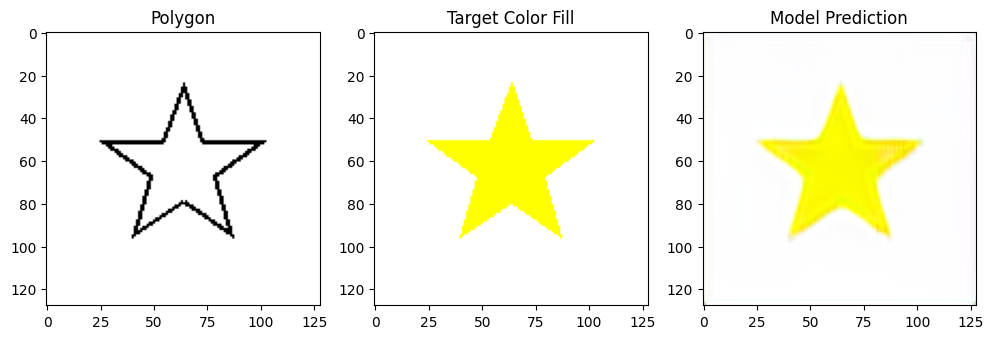

In [14]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    # Pick one validation example
    input_img, color_vec, true_img = val_dataset[0]
    input_img = input_img.unsqueeze(0).to(device)
    color_vec = color_vec.unsqueeze(0).to(device)
    conditioned_in = condition_input(input_img, color_vec)
    pred_img = model(conditioned_in).squeeze().cpu().permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(input_img.squeeze().cpu(), cmap='gray')
    plt.title('Polygon')
    plt.subplot(1,3,2)
    plt.imshow(true_img.permute(1,2,0))
    plt.title('Target Color Fill')
    plt.subplot(1,3,3)
    plt.imshow(pred_img.clip(0,1))
    plt.title('Model Prediction')
    plt.show()
